<a href="https://colab.research.google.com/github/jzitelli/deepxde-experiments/blob/main/amp_phase_helmholtz_plane_wave_dirichlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solve a basic benchmark problem (plane wave solution) using an amplitude / phase formulation of the Helmholtz problem with Physics-Informed Neural Network (PINN)


# Technical References:
1. DeepXDE: A deep learning library for solving differential equations
  
  Lu, Lu and Meng, Xuhui and Mao, Zhiping and Karniadakis, George Em

  https://github.com/lululxvi/deepxde
  
2. A fast Helmholtz solver for high wavenumbers
  
  Y.H. Wijnant, C.H. Venner
  
  30th International Conference on Noise and Vibration engineering (ISMA2022) 2022

3. Solving the Helmholtz equation in terms of amplitude and phase; revisited

  Y.H. Wijnant, C.H. Venner 2014

# Basic idea

The basic idea is to solve the Helmholtz PDE

$$
\nabla^2 P + k^2 P = 0.
$$

But instead of solving directly for the complex-valued variable $P$ (which is typically an oscillating function which becomes more challenging to approximate and solve as wavenumber $k$ increases), we take the representation

$$
P(\vec{x}) = A(\vec{x}) e^{i \phi(\vec{x})}
$$

and solve for the real-valued amplitude $A$ and phase $\phi$.  The motivation for this approach is that for many typical propagating wave solutions, $A$ and $\phi$ are non-oscillating and much easier to approximate numerically than $P$.

See reference [2] for more details.

In [ ]:
!pip install deepxde

In [ ]:
import os
import numpy as np
# os.environ['DDE_BACKEND'] = 'jax'
# os.environ['DDE_BACKEND'] = 'paddle'
import deepxde as dde
from deepxde.backend import tf
from PIL import Image
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



In [ ]:
# Problem parameters
k0 = 4   # wavenumber
amplitude = 2.0   # plane wave amplitude
theta = 0.5 * np.pi / 4   # plane wave angle of propagation
wave_dir = np.cos(theta), np.sin(theta)
length = 2 * np.pi   # size of computational domain

# Exact solution

In the example Helmholtz boundary value problem solved here, the solution is a plane wave

$$
P(\vec{x}) = A_0 e^{i \vec{k} \cdot \vec{x}}
$$

where $|\vec{k}| = k$, with the vector $\vec{k}$ pointing in the direction of the plane wave propagation.  The constant $A_0$ is the amplitude of the wave.

So with the representation $P = A e^{i \phi}$,
$A$ is a constant function

$$
A(\vec{x}) = A_0,
$$

and $\phi$ is a linear function

$$
\phi(\vec{x}) = \vec{k} \cdot \vec{x}.
$$

Very simple functions to approximate!

Following the PINN best practice of scaling the network outputs so that they are of similar magnitudes, we will rescale $\phi$ according to the wavenumber $k$, i.e. the network output will be $\hat{\phi}$, where

$$
\phi(\vec{x}) = k \hat{\phi}(\vec{x}).
$$

In [ ]:
# define the plane wave solution in terms of amplitude (first component) and phase (second component)
def exact_sol(x):
    return np.hstack((amplitude*np.ones((x.shape[0], 1), dtype=x.dtype),
                      (wave_dir[0] * x[:,0] + wave_dir[1] * x[:,1]).reshape(x.shape[0], 1)))

In [ ]:
# Computational domain
outer = dde.geometry.Rectangle([-length / 2, -length / 2], [length / 2, length / 2])
geom = outer

# PDE in terms of $A$ and $\phi$

By performing the substitution $P = A e^{i\phi}$ and applying the product and chain rules, we convert the Helmholtz PDE

$$
\nabla^2 P + k^2 P = 0
$$

to a pair of equations (corresponding to the real and imaginary parts) in terms of amplitude $A$ and phase $\phi$:

$$
\nabla^2 A + (k^2 - \nabla \phi \cdot \nabla \phi) A = 0
\\
A \nabla^2 \phi + 2 \nabla A \cdot \nabla \phi = 0
$$

This **non-linear**, **coupled** PDE with **non-unique** solutions (without imposing additional constraints on $A$ and $\phi$, e.g. requiring amplitude $A$ is positive) has me running scared if I am trying to solve it with finite elements... but in the framework of PINN, these features need no special consideration!  

In [ ]:
# Definition of the pde
def pde(x, y):
    A = y[:, 0]
    phi = k0*y[:, 1]

    A_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    A_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    phi_xx = k0*dde.grad.hessian(y, x, component=1, i=0, j=0)
    phi_yy = k0*dde.grad.hessian(y, x, component=1, i=1, j=1)

    grad_A = dde.grad.jacobian(y, x, i=0)
    grad_phi = k0*dde.grad.jacobian(y, x, i=1)

    return [
        A_xx + A_yy + (k0**2 - grad_phi[:,0] * grad_phi[:,0] - grad_phi[:,1] * grad_phi[:,1]) * A,

        (phi_xx + phi_yy) * A + 2 * (grad_A[:,0] * grad_phi[:,0] + grad_A[:,1] * grad_phi[:,1])
    ]

# Boundary conditions

We are solving a homogeneous PDE, so the solution is determined by the boundary conditions.

With DeepXDE, we can enforce boundary values of $A$ and $\phi$ using the `DirichletBC` class.  We can also use the `OperatorBC` class for more general boundary conditions, such as prescribing values of $P = Ae^{i\phi}$ (corresponding to a Dirichlet BC in the traditional complex-valued Helmholtz formulation).

The `OperatorBC` approach is useful because calculating $\phi$ from a known complex-valued solution $P$ (via e.g. `np.angle`) may result in discontinuities due to the limited range of `np.angle` (i.e. "wrapping").  I don't think the PINN will be able to approximate such artificially introduced discontinuities in $\phi$.  For the plane-wave solution, we already have a simple expression for $\phi$ via a-priori analysis, but still demonstrate the use of `OperatorBC` for such purpose.

In [ ]:
# Boundary conditions
def boundary(x, on_boundary):
    return on_boundary

def boundary_bottom_left(x, on_boundary):
    return on_boundary and outer.on_boundary(x) and not (dde.utils.isclose(x[0], length / 2) or dde.utils.isclose(x[1], length / 2))

def boundary_top_right(x, on_boundary):
    return on_boundary and (dde.utils.isclose(x[0], length / 2) or dde.utils.isclose(x[1], length / 2))

def dirichlet_A(x):
    return amplitude*np.ones(x.shape[0])

def dirichlet_phi(x):
    return (x[:, 0] * wave_dir[0] + x[:, 1] * wave_dir[1]).reshape((-1, 1))


def op_dirichlet_func(x, y, x_numpy):
    # given the network output variables A and phi, and the known complex plane wave solution P,
    # imposes the condition (Dirichlet BC for the traditional complex solution variable):
    # A e^{i phi} - p = 0

    A = y[:, 0]
    phi = k0*y[:, 1]

    cos_phi = tf.cos(phi)
    sin_phi = tf.sin(phi)
    kdotx = k0 * (x[:, 0] * wave_dir[0] + x[:, 1] * wave_dir[1])

    real = A * cos_phi - amplitude * tf.cos(kdotx)
    imag = A * sin_phi - amplitude * tf.sin(kdotx)

    return real**2 + imag**2

def op_neumann_func(x, y, x_numpy):
    # given the network output variables A and phi, and the known complex plane wave solution P,
    # imposes the condition (Neumann BC for the traditional complex solution variable):
    # grad(A e^{i phi}) dot n - (grad p) dot n = 0

    A = y[:, 0]
    phi = k0*y[:, 1]

    grad_A = dde.grad.jacobian(y, x, i=0)
    grad_phi = k0*dde.grad.jacobian(y, x, i=1)

    normal = -outer.boundary_normal(x_numpy)
    # dA_dn = tf.reduce_sum(grad_A * normal, axis=1)
    # dphi_dn = tf.reduce_sum(grad_phi * normal, axis=1)
    dA_dn = grad_A[:,0] * normal[:,0] + grad_A[:,1] * normal[:,1]
    dphi_dn = grad_phi[:,0] * normal[:,0] + grad_phi[:,1] * normal[:,1]

    cos_phi = tf.cos(phi)
    sin_phi = tf.sin(phi)
    kdotn = k0 * (wave_dir[0] * normal[:, 0] + wave_dir[1] * normal[:, 1])
    kdotx = k0 * (x[:, 0] * wave_dir[0] + x[:, 1] * wave_dir[1])

    real = dA_dn * cos_phi - A * dphi_dn * sin_phi + amplitude * kdotn * tf.sin(kdotx)
    imag = dA_dn * sin_phi + A * dphi_dn * cos_phi - amplitude * kdotn * tf.cos(kdotx)
    return real**2 + imag**2

bcs = [
    dde.DirichletBC(geom, dirichlet_A, boundary_bottom_left, component=0),
    dde.DirichletBC(geom, dirichlet_phi, boundary_bottom_left, component=1),
    dde.OperatorBC(geom, op_dirichlet_func, boundary_top_right)
]
loss_weights = [1/k0**2, 1/k0,
                1, 1, 0.01]

# Define and train the PINN with DeepXDE

In [ ]:
# define the network / model / training parameters
learning_rate = 1e-4
num_dense_layers = 2
num_dense_nodes = 20
activation = "sin"

nx = 32 # loss function sampling resolution (may need to adjust for implemented OperatorBCs at higher k0)

vertices = np.array([[-length / 2, -length / 2], [length / 2, -length / 2], [length / 2, length / 2], [-length / 2, length / 2]])

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx**2,
    num_boundary=32 * nx,
    num_test=4 * nx**2,
    solution=exact_sol,
    # exclusions=vertices,
)
net = dde.maps.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)
model = dde.Model(data, net)

model.compile(
    "adam", lr=learning_rate, loss_weights=loss_weights, metrics=["l2 relative error"]
)

Compiling model...
Building feed-forward neural network...
'build' took 0.063759 s

'compile' took 1.715520 s



In [ ]:
class MovieDumper2D(dde.callbacks.Callback):
    """Dump a movie (animated GIF) showing the evolution of model prediction
    over the 2D domain as the training progresses.
    """

    def __init__(
        self,
        filename,
        geom,
        num_points=128,
        period=1,
        component=0,
        transform=None,
        **kwargs
    ):
        super().__init__()
        self.filename = filename
        self.geom = geom
        x_min, y_min = self.geom.bbox[0]
        x_max, y_max = self.geom.bbox[1]
        aspect = (x_max - x_min) / (y_max - y_min)
        x1 = np.linspace(x_min, x_max, int(aspect * num_points))
        x2 = np.linspace(y_min, y_max, num_points)
        X1, X2 = np.meshgrid(x1, x2)
        self.X1 = X1
        self.X2 = X2
        self.points = np.dstack((X1, X2)).reshape(-1, 2)
        self.inside_mask = geom.inside(self.points).reshape(X1.shape)
        self.period = period
        self.component = component
        self.epochs_since_last_save = 0
        self.frames = []
        self.kwargs = kwargs

    def on_epoch_end(self):
        self.epochs_since_last_save += 1
        frames = self.frames
        filename = self.filename
        if self.epochs_since_last_save >= self.period:
            y_pred = self.model.predict(self.points)
            y_pred = y_pred[:, self.component].reshape(self.X1.shape)
            y_pred[~self.inside_mask] = 0
            plt.figure()
            plt.title(f'{filename}: epoch {self.model.train_state.iteration:06}')
            plt.pcolormesh(self.X1, self.X2, y_pred,
                           shading='auto', cmap='coolwarm', **self.kwargs)
            plt.colorbar()
            filename = f"{filename}_{len(frames):03d}.png"
            plt.savefig(filename)
            plt.close()
            self.epochs_since_last_save = 0
            frames.append(Image.open(filename))

    def on_train_end(self):
        fname_movie = self.filename + "_y.gif"
        self.frames[0].save(f"{self.filename}.gif", save_all=True, append_images=self.frames[1:], duration=40, loop=0)

In [ ]:
# train the model
losshistory, train_state = model.train(iterations=20000,
                                       callbacks=[MovieDumper2D('amp-phase-plane-wave-A',
                                                                geom, num_points=256, period=100,
                                                                component=0),
                                                  MovieDumper2D('amp-phase-plane-wave-phi',
                                                                geom, num_points=256, period=100,
                                                                component=1)])

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.87e+00, 1.58e-01, 2.68e+00, 2.09e+00, 2.15e-01]    [1.55e+00, 1.79e-01, 2.68e+00, 2.09e+00, 2.15e-01]    [8.06e-01]    
1000      [3.72e-01, 3.10e-01, 1.44e+00, 2.39e-02, 1.34e-01]    [2.58e-01, 3.45e-01, 1.44e+00, 2.39e-02, 1.34e-01]    [5.35e-01]    
2000      [2.38e-02, 1.09e-01, 5.81e-02, 8.18e-04, 2.39e-03]    [2.33e-02, 1.21e-01, 5.81e-02, 8.18e-04, 2.39e-03]    [1.32e-01]    
3000      [5.04e-03, 1.44e-02, 2.21e-03, 1.14e-04, 9.13e-06]    [5.16e-03, 9.73e-03, 2.21e-03, 1.14e-04, 9.13e-06]    [1.72e-02]    
4000      [2.02e-03, 5.92e-03, 3.91e-04, 4.23e-05, 8.44e-07]    [2.19e-03, 4.51e-03, 3.91e-04, 4.23e-05, 8.44e-07]    [8.58e-03]    
5000      [9.91e-04, 3.03e-03, 1.19e-04, 1.18e-05, 8.94e-08]    [1.12e-03, 2.57e-03, 1.19e-04, 1.18e-05, 8.94e-08]    [5.42e-03]    
6000      [5.17e-04, 1.69e-03, 3.87e-05, 2.53e-06,

# Visualize the results

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


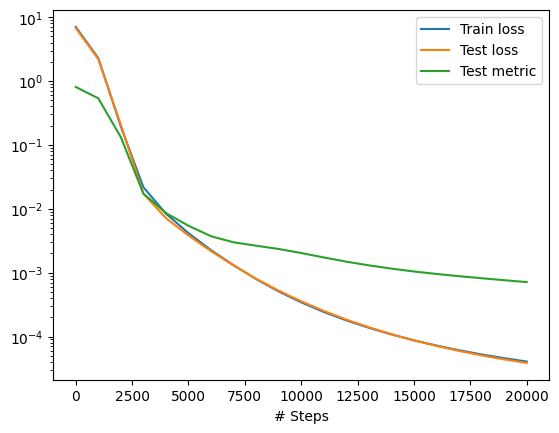

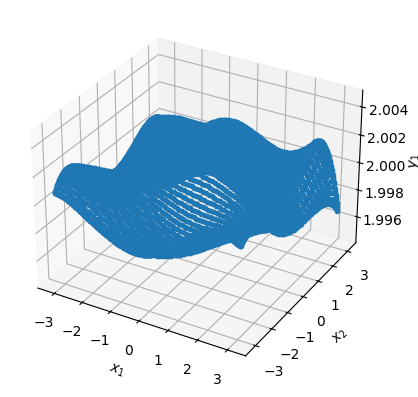

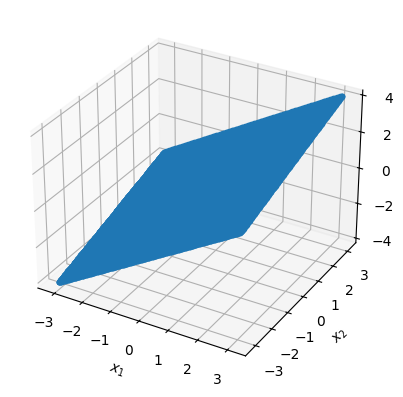

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

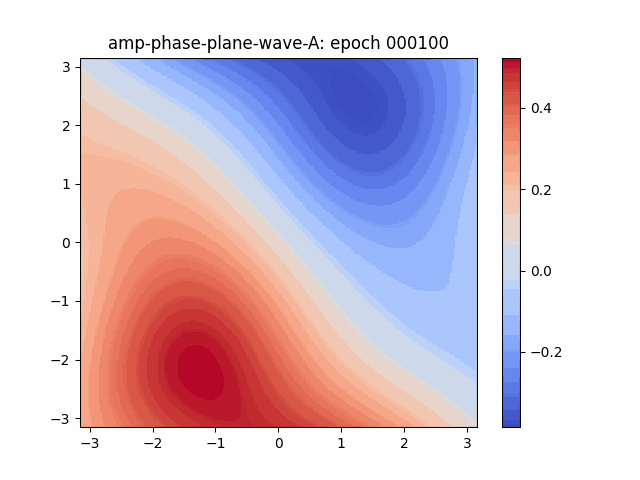

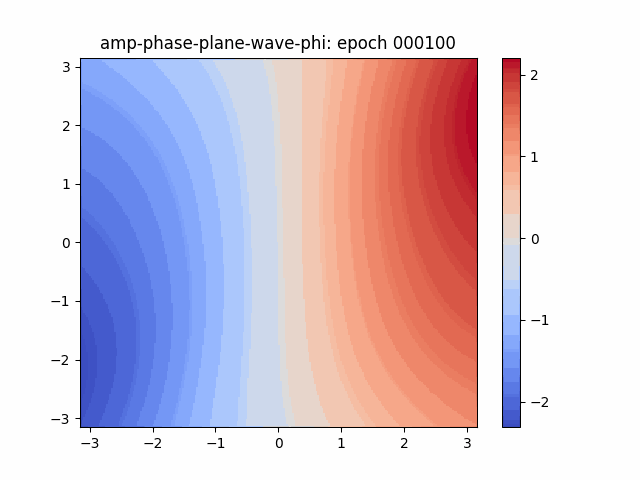

In [ ]:
from IPython.display import display, Image as IPImage
display(IPImage('amp-phase-plane-wave-A.gif'))
display(IPImage('amp-phase-plane-wave-phi.gif'))

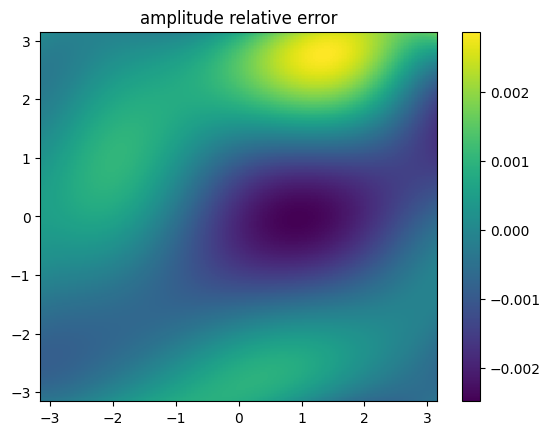

In [ ]:
import matplotlib.pyplot as plt

x_min, x_max = -length / 2, length / 2
y_min, y_max = -length / 2, length / 2
num_points = 256

x1 = np.linspace(x_min, x_max, num_points)
x2 = np.linspace(y_min, y_max, num_points)
X1, X2 = np.meshgrid(x1, x2)

y_pred = model.predict(np.dstack((X1, X2)).reshape(-1, 2))

plt.figure()
plt.pcolormesh(X1, X2, (amplitude - y_pred[:,0].reshape(X1.shape))/amplitude, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('amplitude relative error')
plt.show()

## Transform the model outputs $A$ and $\hat{\phi}$ into the complex-valued solution $P$ for visualization:

In [ ]:
P = y_pred[:,0].reshape(X1.shape) * np.exp(1j*k0*y_pred[:,1].reshape(X1.shape))

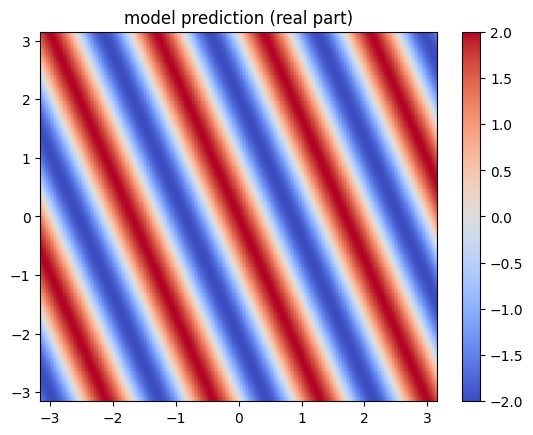

In [ ]:
plt.figure()
plt.pcolormesh(X1, X2, P.real, shading='auto', cmap='coolwarm')
plt.colorbar()
plt.title('model prediction (real part)')
plt.show()

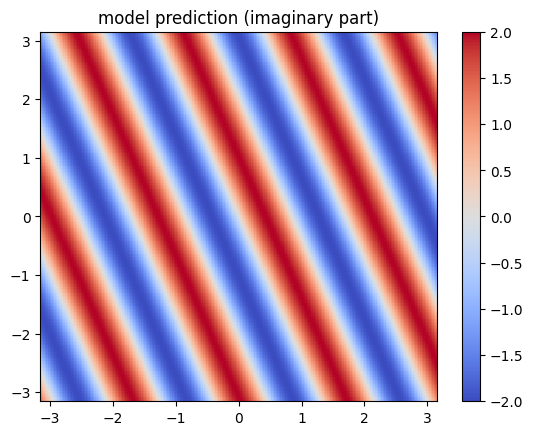

In [ ]:
plt.figure()
plt.pcolormesh(X1, X2, P.imag, shading='auto', cmap='coolwarm')
plt.colorbar()
plt.title('model prediction (imaginary part)')
plt.show()